In [1]:
from SimPEG import *
from simpegEM1D import (
    EM1D, EM1DSurveyTD, Utils1D, get_vertical_discretization_time, 
    set_mesh_1d
)
import numpy as np
import pandas as pd
import os
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## load TEMFAST data

In [2]:
temfast_data = pd.read_table(os.path.sep.join(['./', 'dados.txt']))  #Load data file
fname = 'T1P1_1d'
fnameinv = fname+'_inv'
fnameforw = fname+'_forw'
fnameconduc = fname+'_coduct'

## plot data

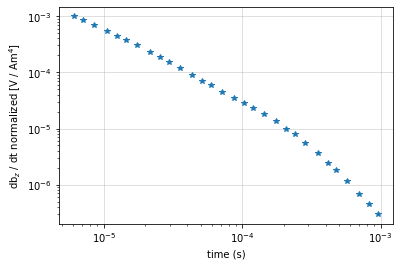

In [3]:
#Plot real data 
size_loop = 25 
loop_area = size_loop**2
neg_dobs = temfast_data[(temfast_data['E_I'] < 0 )].index
temfast_data.drop(neg_dobs, inplace = True) #drops negative values
time_channels = (temfast_data.Time[:].values)[2:-12]*1e-6  # deleted the last 4 values 
dobs = temfast_data.E_I[:].values[2:-12]/loop_area # [V/A]
dobs = dobs #[V/Am^2]

fig, ax = plt.subplots(1, 1)
ax.loglog(time_channels, dobs, '*')
ax.set_xlabel("time (s)")
ax.set_ylabel("db$_z$ / dt normalized [V / Am$^4$]")
ax.grid("k", alpha=0.5)
ax.set_rasterized(True)

In [4]:
dobs

array([9.8400e-04, 8.6080e-04, 6.8160e-04, 5.3760e-04, 4.4640e-04,
       3.7440e-04, 3.0240e-04, 2.3360e-04, 1.8880e-04, 1.5488e-04,
       1.2160e-04, 9.0400e-05, 7.0880e-05, 5.8240e-05, 4.4480e-05,
       3.4880e-05, 2.8000e-05, 2.2880e-05, 1.8080e-05, 1.3472e-05,
       9.9840e-06, 7.8560e-06, 5.5200e-06, 3.6320e-06, 2.4640e-06,
       1.8240e-06, 1.1616e-06, 6.7360e-07, 4.5920e-07, 3.0080e-07])

## set the current waveform

In [5]:
input_currents = np.array([0, 1, 1, 0], dtype=float)
time_input_currents = np.array([0, 1e-4, 2e-4, 2e-4+8e-6])
radius = np.sqrt(loop_area/np.pi)
srcloc = np.array([0., 0., 0.], dtype=float) # source coord
rxloc = np.array([0., 0., 0.], dtype=float) # source coord

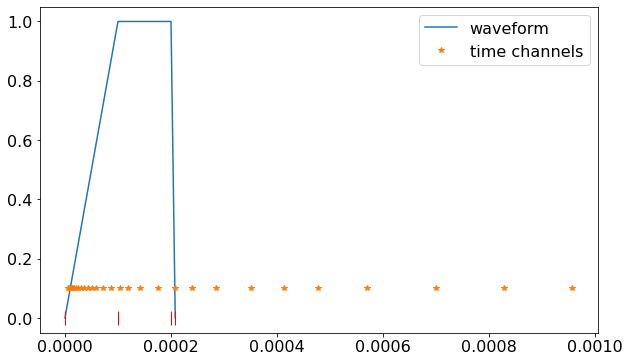

In [16]:
fig,ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(time_input_currents, input_currents,label='waveform')
ax.plot(time_input_currents, np.zeros(len(time_input_currents)), 'r|', ms=14)
ax.plot(time_channels,0.1*np.ones(len(time_channels)),'*',label='time channels')
plt.rcParams.update({'font.size': 16})
plt.legend()

## set survey and problem

In [7]:
from simpegEM1D import skytem_HM_2015
hz = 1.1**np.arange(19) 
mesh1D = set_mesh_1d(hz)
depth = -mesh1D.gridN[:-1]
TDsurvey = EM1DSurveyTD(
    rx_location = rxloc,
    src_location = srcloc,
    topo = np.r_[0., 0., 0.],
    depth = depth,
    rx_type = 'dBzdt',
    wave_type = 'general',
    src_type = 'CircularLoop',
    a = radius,
    time = time_channels,
    input_currents=input_currents,
    time_input_currents=time_input_currents,
    base_frequency=100,
    n_pulse=1
)
expmap = Maps.ExpMap(mesh1D)
prob = EM1D(mesh1D, sigmaMap=expmap, verbose=False)
if prob.ispaired:
    prob.unpair()
if TDsurvey.ispaired:
    TDsurvey.unpair()
prob.pair(TDsurvey)
std = 0.05
floor = 0.
TDsurvey.dobs = -dobs
dmisfit = DataMisfit.l2_DataMisfit(TDsurvey)
uncert = (abs(TDsurvey.dobs)*std+floor)
dmisfit.W = 1./ uncert
m0 = np.log(np.ones_like(hz)*1/3.)

SimPEG.DataMisfit.l2_DataMisfit assigning default std of 5%
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||


In [8]:
print(m0)

[-1.09861229 -1.09861229 -1.09861229 -1.09861229 -1.09861229 -1.09861229
 -1.09861229 -1.09861229 -1.09861229 -1.09861229 -1.09861229 -1.09861229
 -1.09861229 -1.09861229 -1.09861229 -1.09861229 -1.09861229 -1.09861229
 -1.09861229]


In [9]:
dpred = TDsurvey.dpred(m0)

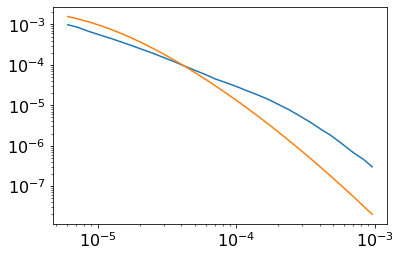

In [10]:
plt.loglog(time_channels, -TDsurvey.dobs)
plt.loglog(time_channels, -dpred)

## run inversion

In [11]:
reg = Regularization.Tikhonov(
    mesh1D,
    mapping=Maps.IdentityMap(mesh1D),
    alpha_s=1.,
    alpha_x=1.
)
opt = Optimization.ProjectedGNCG(maxIter=25, maxIterCG=20)
invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
beta = Directives.BetaSchedule(coolingFactor=2., coolingRate=1)
betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1e0)
target = Directives.TargetMisfit()
inv = Inversion.BaseInversion(invProb, directiveList=[beta, betaest, target])
prob.counter = opt.counter = Utils.Counter()
opt.LSshorten = 0.5
opt.remember('xc')

In [12]:
mopt = inv.run(m0)

SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  6.68e+01  2.65e+03  0.00e+00  2.65e+03    1.05e+03      0              
   1  3.34e+01  1.46e+03  3.64e+00  1.58e+03    4.00e+02      0              
   2  1.67e+01  6.20e+02  1.22e+01  8.24e+02    4.11e+02      0              
   3  8.35e+00  7.07e+01  2.28e+01  2.62e+02    1.50e+02      0              
   4  4.18e+00  1.55e+01  2.38e+01  1.15e+02    2.67e+01      0   Skip BFGS  
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 2.6513e+02
1 : |xc-x_last| = 3.9936e-01 

Text(0.5, 0, 'Resistivity (ohm-m)')

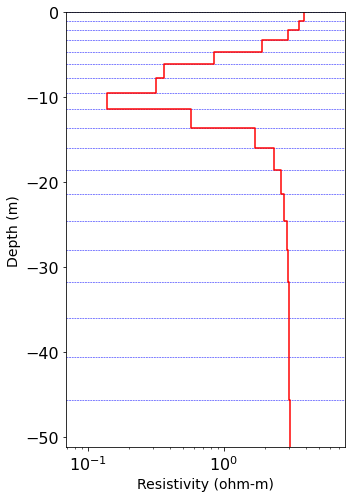

In [13]:
fig, ax = subplots(1,1, figsize=(5, 8))
Utils1D.plotLayer(1./(expmap*mopt), mesh1D, showlayers=True, **{'color':'r'})
plt.xlabel("Resistivity (ohm-m)")
# Utils1D.plotLayer(expmap*invProb.l2model, mesh1D, showlayers=False, **{'color':'b', 'lw':1.})

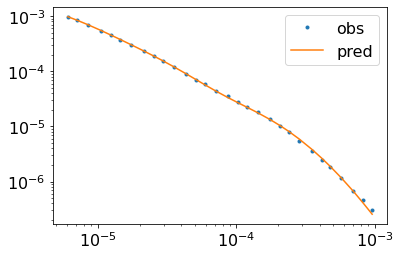

In [14]:
plt.loglog(time_channels, -TDsurvey.dobs, '.')
plt.loglog(time_channels, -invProb.dpred)
plt.legend(("obs", "pred"))